In [1]:
import pickle

ensembles = []

for i in range(0,2):
    ensembles.append(pickle.load(open(f'../{i}_rollout_v_predictions_30year_ssp_585_20e12882.pkl', 'rb')))
num_steps = len(ensembles[0]['state_surface'])

In [2]:
#from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
#from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
#os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)


[rank: 0] Seed set to 0
356it [00:50,  7.02it/s]
36it [00:05,  6.80it/s]


In [ ]:
#LOAD BATCH DATA
batch_timeseries = []
batch_iter = iter(train_dataloader)
val.timestamps
for b in range(num_steps * 6):
    print(b)
    batch = next(batch_iter)
    batch_timeseries.append(batch)
import numpy as np


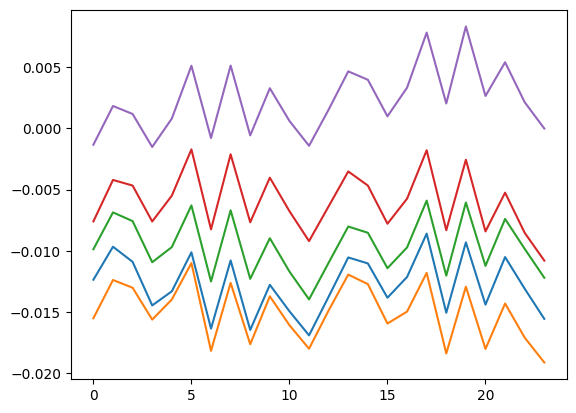

In [4]:
batch_timeseries_state = [x['state_surface'] for x in batch_timeseries]
ipsl_ensemble = np.stack(np.array_split(np.stack(batch_timeseries_state[:118 * 3 * 6]),6)[:-1])
ipsl_ensemble[ipsl_ensemble == 0] = 'nan'
import matplotlib.pyplot as plt
for i in ipsl_ensemble:
    plt.plot(np.nanmean(i[:24,0,4],axis=(-1,-2)))

In [5]:
batch_denormed = []
denormed_ensembles = []
denormed_batch_ensembles = []
for i in range(1):
    month_index = 0
    denormalized = []
    batch_denormed = []
    for index in range(num_steps-6):
   # for index in range(len(ensembles[i]['state_surface'])-2):
        denorm_surface = lambda x,month_index: x*torch.from_numpy(train.surface_stds[month_index]) + torch.from_numpy(train.surface_means[month_index])
        denormalized.append(denorm_surface(ensembles[i]['state_surface'][index],month_index))
        batch_denormed.append(denorm_surface(torch.Tensor(ipsl_ensemble[i][index]),month_index))
        if(month_index == 11):
            month_index = 0
        else:
            month_index += 1
    denormed_ensembles.append(denormalized)
    denormed_batch_ensembles.append(batch_denormed)


# for i in ensemble0['state_surface']:
#     print(i.shape)

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = ensembles[0]['state_surface'][0][0][3]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = ensembles[-1]['state_surface'][-1][0][3]
shell[var_name].plot.pcolormesh(ax=ax2)

In [ ]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(1, figsize=(16, 6))
container = []
for time_step in range(num_steps):
    shell['tas'].data = denormalized[time_step][0][4]
    #shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
    title = ax1.text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes, )
    container.append([line, title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=100, blit=True)
ani.save("diffusion_gpp_ssp_585_30_year.gif")

In [ ]:
import numpy as np
for i in ensembles:
    plt.plot(np.mean(np.stack(i['state_surface'])[:,0,3],axis=(-1,-2)))

In [ ]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

In [ ]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_batch_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,0],axis=(-1,-2)))

In [ ]:
pred_avged = pred[:,:,0].reshape(pred.shape[0], -1, 6)

In [66]:
def moving_average(a, n=10000):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [65]:
np.cumsum(pred)

(65606112,)

In [13]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [14]:
moving_average(pred,10)

ValueError: object too deep for desired array

In [ ]:
#comparing trend metrics 
# compute the slope and check r2 of the slopes 

In [67]:
avg = moving_average(pred,n=12)

In [62]:
avg[::100].shape

(656062,)

In [ ]:
plt.plot(avg)

In [34]:
pred_avged.shape

(354, 30888)

In [ ]:
plt.plot(pred_avged)

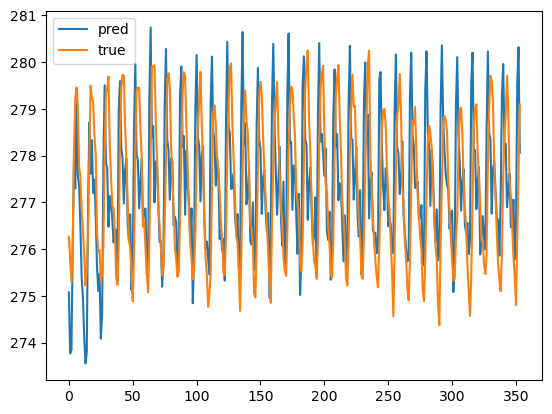

In [10]:
pred = np.stack(denormalized)
plt.plot(np.nanmean(pred[:,0,0],axis=(-1,-2)),label='pred')
plt.plot(np.nanmean(np.stack(batch_denormed)[:,0,0],axis=(-1,-2)),label='true')
plt.legend()

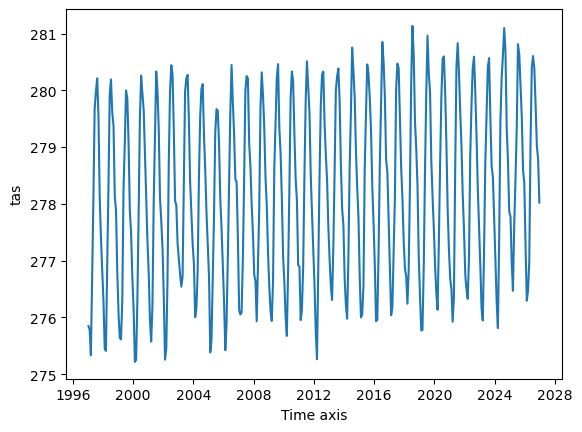

In [12]:
#get 30 year trend from batch 
import xarray as xr 
#just manually open 3 files to check and compare trend
scratch = os.environ['SCRATCH']
var_name = 'tas'
data = []
files = [f'{scratch}/1996_1.nc',f'{scratch}/2006_1.nc',f'{scratch}/2016_1.nc']
for file in files: 
    data.append(xr.open_dataset(file)[var_name])
    
concated = xr.concat(data,dim='time')
concated.mean(dim=['lat','lon']).plot()